In [ ]:
%matplotlib inline
from pylab import *
from sci378 import *

Version:  0.0.38


## Load all the data

Somehow Excel can't handle 19000 columns.  😀

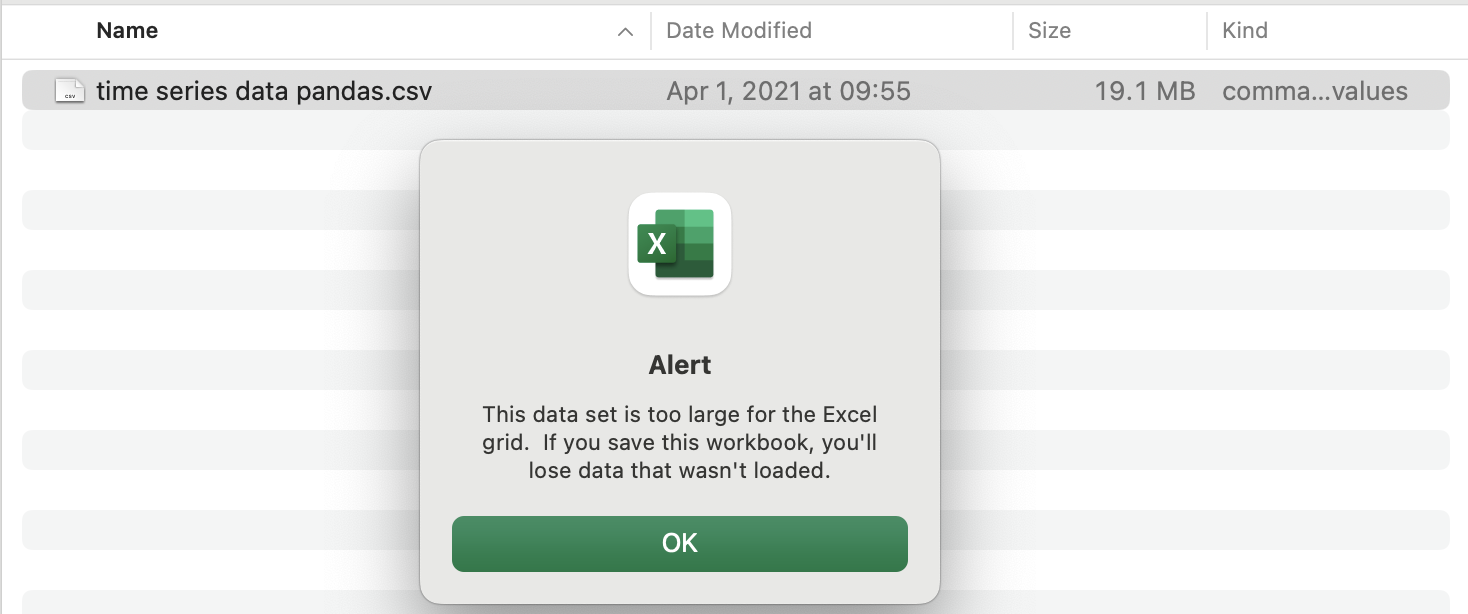

In [ ]:
data=pd.read_csv('data/crichton/time series data pandas.csv.zip')
data.head()

,time,ALBERNI_ROBERTSON_CREEK,VAL_D'OR,WADI_HALFA,SETTAT,SAN_JUAN_DE_LA_MAGUANA,REVELSTOKE_A,LONDON_INT'L_AIRPORT,EUFAULA_WILDLIFE_REF,OAK_MOUNTAIN_CALIFORNIA,...,SANTIAGO_COMPOSTELA,HEMLOCK,LONGVIEW_E_TX_RGNL_AP,LITTLE_SNOWY_MONTANA,YOUNG_POST_OFFICE,KEM,JINGHONG,ICH'ON,VICTORIA_VICTORIA,IRON_RIVER
0,1880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
station_data=pd.read_excel('data/crichton/station_info.xlsx')
station_data

,ID,Station,Latitude,Longitude,Brightness,Elevation
0,ACW00011604,SAVE,57.7667,11.8667,45.0,18.0
1,AE000041196,SHARJAH_INTER_AIRP,25.3330,55.5170,39.0,34.0
2,AEM00041184,RAS_AL_KHAIMAH_INTE,25.6170,55.9330,17.0,31.0
3,AEM00041194,DUBAI_INTL,25.2550,55.3640,104.0,10.4
4,AEM00041216,ABU_DHABI_BATEEN_AIR,24.4300,54.4700,114.0,3.0
...,...,...,...,...,...,...
19805,ZI000067983,CHIPINGE,-20.2000,32.6160,0.0,1132.0
19806,ZI000067991,BEITBRIDGE,-22.2170,30.0000,8.0,457.0
19807,ZIXLT371333,HARARE_BELVEDERE,-17.8300,31.0200,24.0,1471.0
19808,ZIXLT443557,GRAND_REEF,-18.9800,32.4500,0.0,1018.0


## Searching for names

In [ ]:
station_data[station_data['Station'].str.contains('KOLN')]

,ID,Station,Latitude,Longitude,Brightness,Elevation
5650,GME00004298,KOLN_BOTANISCHER_GARTEN,50.9628,6.9717,67.0,45.0
5940,GME00121042,KOLN_BONN,50.8658,7.1583,22.0,92.0


## Plot one of the columns

[<matplotlib.lines.Line2D>]

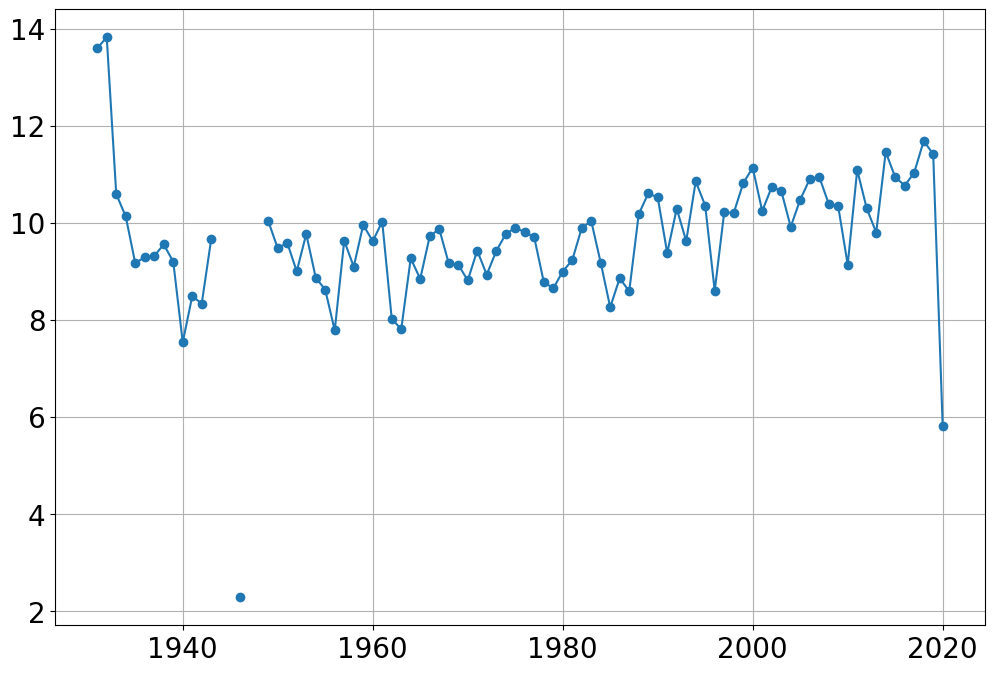

In [ ]:
t,y=data['time'],data['KOLN_BONN']
plot(t,y,'-o')

## Copying from the fitting functions notebook

In [ ]:
def get_temperature_time_slope(station_name,plotit=False):
    from lmfit.models import LinearModel
    
    t,y=data['time'],data[station_name]

    t=t.values[y<500]  # just in case there are weird 999 numbers
    y=y.values[y<500]    
    
    if plotit:
        plot(t,y,'-o')
        
    mymodel=LinearModel()
    result=mymodel.fit(y,x=t)  
    
    if plotit:
        tt=linspace(min(t),max(t),100)
        yy=result.eval(x=tt)
        plot(tt,yy,'r-')


        text(min(t)+5,max(y)-.1,
             f"$y={result.params['slope'].value:.4f}x+{result.params['intercept'].value:.4f}$")    
    
        title(station_name)
    return result.best_values['slope']

In [ ]:
get_temperature_time_slope('KOLN_BONN')

0.013684956768576251

0.013684956768576251

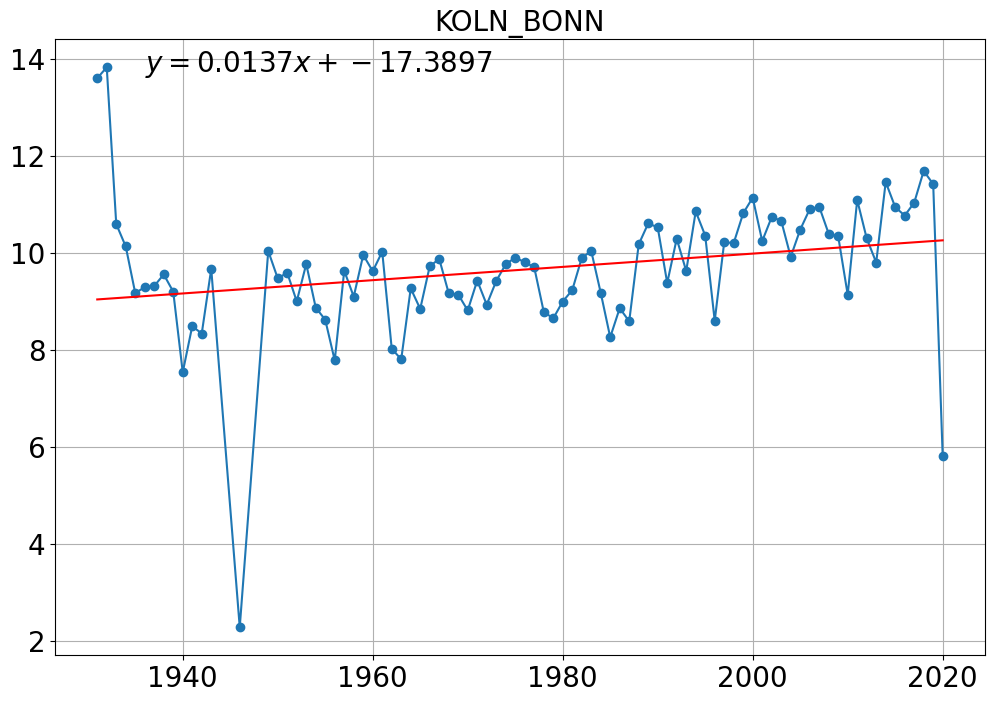

In [ ]:
get_temperature_time_slope('KOLN_BONN',plotit=True)

# Solving the Crichton Problem

- Crichton's claim:
    - CO$_2$ does not drive temperature -- it's urban development
    - urban temperatures have increased over time, but the nearby rural (i.e. undeveloped) areas have not
    
- This means that the slope of urban areas should be positive and close rural areas should be near zero or negative


### Outline

- Go through all of the stations with BI>10 (urban)
    - for each urban station, find the nearest rural save the pair of (urban slope, rural slope).  We'll call U the urban slope and R the rural slope.
- make a plot of rural slopes vs urban slopes
- Crichton's claim then implies a certain structure of the plot of all these points
    - global warming would have U>0 and R>0, so dots in the upper right
    - Crichton claims that U>0 and R<0, so dots in the lower right
    - global cooling would have U<0 and R<0, so dots in the lower left
    - there's a weird corner with U<0 and R>0 -- urban cooling rural warming where there shouldn't be any points

The only thing missing is some way to find the neasest rural, once we have a station.  

- The station data has latitude and longitude.  
- the station data has a brightness index, BI>10 for urban

In [ ]:
station_data['urban']=station_data['Brightness']>10

In [ ]:
station_data

,ID,Station,Latitude,Longitude,Brightness,Elevation,urban
0,ACW00011604,SAVE,57.7667,11.8667,45.0,18.0,True
1,AE000041196,SHARJAH_INTER_AIRP,25.3330,55.5170,39.0,34.0,True
2,AEM00041184,RAS_AL_KHAIMAH_INTE,25.6170,55.9330,17.0,31.0,True
3,AEM00041194,DUBAI_INTL,25.2550,55.3640,104.0,10.4,True
4,AEM00041216,ABU_DHABI_BATEEN_AIR,24.4300,54.4700,114.0,3.0,True
...,...,...,...,...,...,...,...
19805,ZI000067983,CHIPINGE,-20.2000,32.6160,0.0,1132.0,False
19806,ZI000067991,BEITBRIDGE,-22.2170,30.0000,8.0,457.0,False
19807,ZIXLT371333,HARARE_BELVEDERE,-17.8300,31.0200,24.0,1471.0,True
19808,ZIXLT443557,GRAND_REEF,-18.9800,32.4500,0.0,1018.0,False


In [ ]:
def closest_rural(name):
    
    # get the location of the named urban site
    latitude_site=float(station_data[station_data['Station']==name]['Latitude'].iloc[0])
    longitude_site=float(station_data[station_data['Station']==name]['Longitude'].iloc[0])

    # calculate the distance away for all stations...
    station_data['dsquared']=(station_data['Latitude']-latitude_site)**2+(station_data['Longitude']-longitude_site)**2    
    # sort by that distance
    sorted_station_data=station_data.sort_values('dsquared')
    
    # find the closest rural station
    rural_site=sorted_station_data.query('urban==False').iloc[0]
    
    return rural_site['Station']

In [ ]:
closest_rural('KOLN_BONN')

'NEUNKIRCHEN_SEELSCHEID_MEISENB'

## Now go through the outline

- For each urban station, find the nearest rural save the pair of (urban slope, rural slope).  We'll call U the urban slope and R the rural slope.

Since this may take a while, use the (weirdly named) tqdm library to show progress.

In [ ]:
from tqdm import tqdm

In [ ]:
names=list(station_data.query('urban==True')['Station'])
print("Number of urban sites:",len(names))

Number of urban sites: 7840


In [ ]:
U=[]
R=[]
for name in tqdm(names):
    U.append(get_temperature_time_slope(name,plotit=False))
    rural_name=closest_rural(name)
    R.append(get_temperature_time_slope(rural_name,plotit=False))

100%|██████████████████████████████████████| 7840/7840 [00:36<00:00, 216.71it/s]


(-0.41608778891484755,
 0.4570164227073492,
 -0.7641958540649479,
 0.7966426944029358)

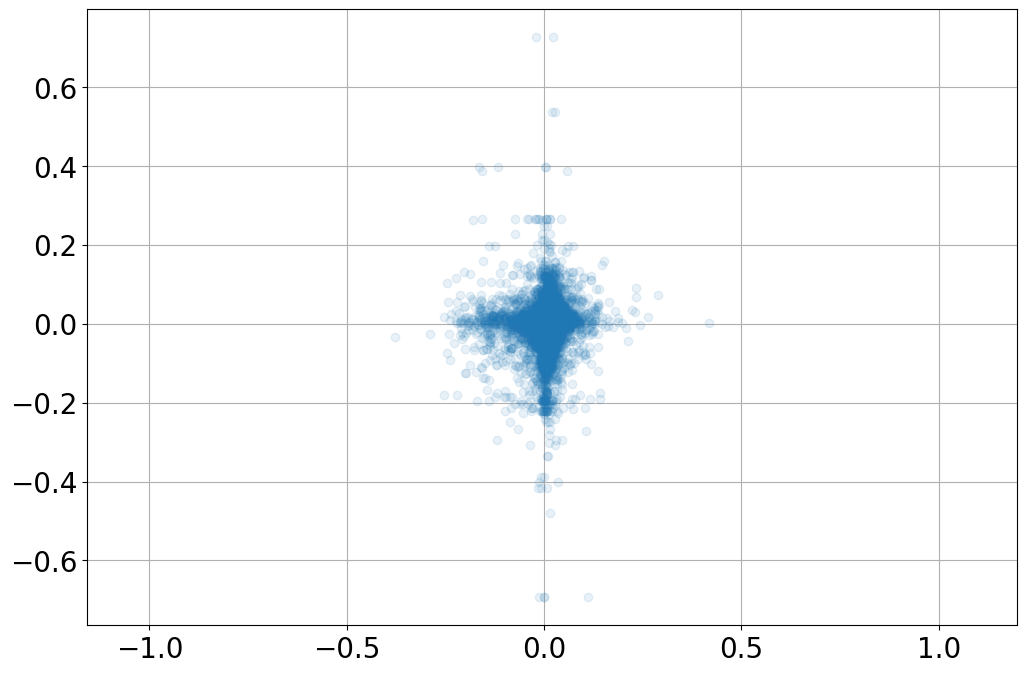

In [ ]:
plot(U,R,'o',alpha=.1)
axis('equal')

## Questions to explore

- How do the means of the slopes differ between urban and rural?
- How do the standard deviations of the slopes differ between urban and rural?
- What does this mean?
- Is there any evidence of upward curvature in the temperature-time curves for urban sites?  (i.e. fit to a quadratic, and look for values of "a" greater than zero)
- What about for rural sites?